In [59]:
import os
import pandas as pd
import re
import numpy as np
import glob

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [60]:
# This was used to train and read on the original company code


def read_cobol(file_path):
    sections: list[str] = []
    importances: list[int] = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    isin_section = False
    reached_main = False
    current_section = ""
    for line in lines:
        if not reached_main:
            if "PROCEDURE DIVISION." not in line:
                continue
            reached_main = True
            isin_section = True
            current_section = line
            continue

       
        if "SECTION." not in line:
            if not isin_section:
                continue
            current_section += line
            continue
        
        # print("Add section", line)
        isin_section = True
        sections.append(current_section)
        current_section = line
        if "*>IMPORTANT" in line:
            importances.append(1)
        else:
            importances.append(0)

    print(file_path, "Total Sections", len(sections), len(importances), "important: ", sum(importances))
    return sections, importances

files = glob.glob("..\\data\\*.cbl")

sections = []
importances = []

for file in files:
    c_sections, c_importances = read_cobol(file)
    sections = sections + c_sections
    importances = importances + c_importances

print("total: ", len(sections), "importance rate", sum(importances) / len(sections))

..\data\sample1.cbl Total Sections 94 94 important:  20
..\data\sample2.cbl Total Sections 58 58 important:  13
..\data\sample3.cbl Total Sections 37 37 important:  1
..\data\sample4.cbl Total Sections 37 37 important:  1
..\data\sample5.cbl Total Sections 81 81 important:  16
..\data\sample6.cbl Total Sections 68 68 important:  16
total:  375 importance rate 0.17866666666666667


In [61]:
data = pd.DataFrame({"section": sections, "importances": importances}, columns=["section", "importances"])

regex_target = "[^a-zA-z0-9\s\-]" # include -
# regex_target = "[^a-zA-z0-9\s]" # exclude -

data['section'] = data['section'].apply((lambda x: re.sub(regex_target,'',x)))

max_fatures = 2000
tokenizer =  Tokenizer(num_words=max_fatures, split=' ', filters='-!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(data['section'].values)
X = tokenizer.texts_to_sequences(data['section'].values)
X = pad_sequences(X)


# data
for i in range(11):
    word = list(tokenizer.word_index.keys())[i]
    count = tokenizer.word_counts[word]
    print(word, count)




to 2570
fwt 2528
move 1862
perform 1186
map 1038
exit 845
end 691
if 689
issf100 522
mod 515
exec 448


In [62]:
# Y = data['importances'] # for sigmoid
Y = pd.get_dummies(data['importances']).values # for softmax
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 235
Val size: 102
Test size: 38


In [63]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.3))
model.add(Dense(2,activation='softmax'))
# model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0005),metrics = ['accuracy'])
# model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(0.0005),metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 938, 32)           64000     
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 938, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 72,386
Trainable params: 72,386
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
history = model.fit(X_train, Y_train, epochs = 16, batch_size=16, verbose=1, validation_data=(X_train, Y_train))

Epoch 1/16
15/15 [==============================] - 5s 131ms/step - loss: 0.6746 - accuracy: 0.7702 - val_loss: 0.6493 - val_accuracy: 0.8255
Epoch 2/16
15/15 [==============================] - 1s 65ms/step - loss: 0.6147 - accuracy: 0.8255 - val_loss: 0.5523 - val_accuracy: 0.8255
Epoch 3/16
15/15 [==============================] - 1s 63ms/step - loss: 0.4849 - accuracy: 0.8255 - val_loss: 0.4523 - val_accuracy: 0.8255
Epoch 4/16
15/15 [==============================] - 1s 64ms/step - loss: 0.4294 - accuracy: 0.8255 - val_loss: 0.4154 - val_accuracy: 0.8255
Epoch 5/16
15/15 [==============================] - 1s 76ms/step - loss: 0.4015 - accuracy: 0.8255 - val_loss: 0.3712 - val_accuracy: 0.8255
Epoch 6/16
15/15 [==============================] - 1s 95ms/step - loss: 0.3516 - accuracy: 0.8255 - val_loss: 0.3084 - val_accuracy: 0.8255
Epoch 7/16
15/15 [==============================] - 1s 74ms/step - loss: 0.2800 - accuracy: 0.8255 - val_loss: 0.2630 - val_accuracy: 0.8383
Epoch 8/16
1

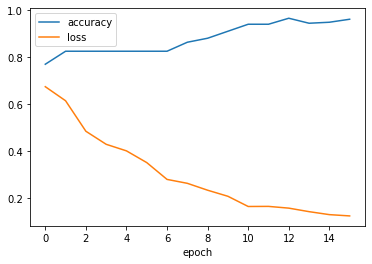

In [65]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['loss'])
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'loss'], loc='upper left')
  plt.show()

plot_history(history)


In [66]:
model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 56ms/step - loss: 0.3335 - accuracy: 0.8947


[0.3334953784942627, 0.8947368264198303]

In [67]:
predits = model.predict(X_test)

important_predicts = []

for i in range(len(predits)):
    item = predits[i]
    value = item[1]
    if value > 0.5:
        print(i, item)
        important_predicts.append(value)

print(np.mean(important_predicts))



2/2 [==============================] - 1s 94ms/step
1 [0.20763707 0.79236287]
2 [0.48042008 0.51957995]
3 [0.2400217  0.75997823]
7 [0.32373247 0.67626756]
10 [0.22601347 0.7739865 ]
20 [0.21398862 0.78601146]
26 [0.25570336 0.74429667]
30 [0.38799667 0.6120033 ]
31 [0.41725194 0.58274806]
34 [0.3107675  0.68923247]
37 [0.3370016  0.66299844]
0.6908605
